/home/fabiola/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
/home/fabiola/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in double_scalars
/home/fabiola/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in sqrt
/home/fabiola/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars
/home/fabiola/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: ComplexWarning: Casting complex values to real discards the imaginary part
/home/fabiola/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in sqrt
/home/fabiola/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in sqrt
/home/fabiola/minico

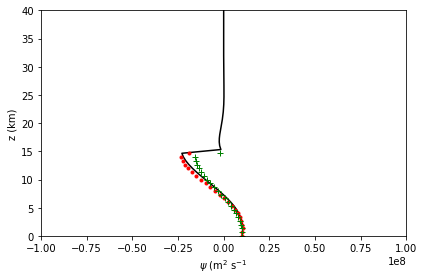

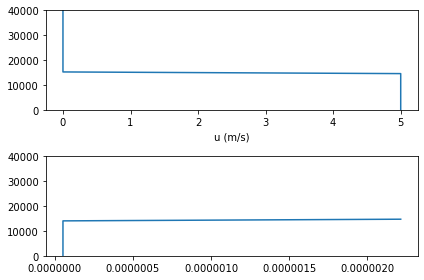

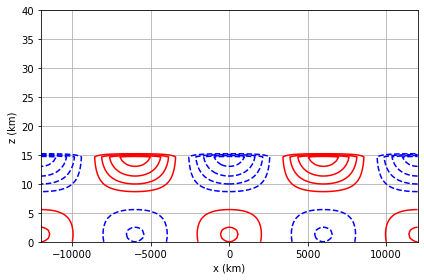

In [41]:
# Solve vertically propagating Rossby wave problem.
# pylint: disable = invalid-name, C0111
# from pylab import *
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

plt.close("all")


# %% !------------------------------------------------------------------------!
def set_arrays(n, delta, tau, k, f0, beta, hscale, c0, cnp1, z):

    a = np.zeros((n, n), dtype=np.complex)
    f = np.zeros(n, dtype=np.complex)

    for jj in range(n):
        zj = z[jj]
        zm = zj-delta/2

        zp = zj+delta/2
        # in this code "1j" symbolizes the complex "i"
        # so u(zj)-1j/tau*k corresponds to U-i/(\tau\kappa) in the assignment
        am = (u(zj)-1j/(tau*k))/(rhos(hscale, zj)*delta**2)
        am = am*rhos(hscale, zm)*f0**2/nbv2(zm)

        ap = (u(zj)-1j/(tau*k))/(rhos(hscale, zj)*delta**2)
        ap = ap*rhos(hscale, zp)*f0**2/nbv2(zp)

        aj = -am - ap + dqdy(delta, f0, beta, hscale, zj) - k**2*u(zj)
        # print jj, zj, zm, zp, am, ap, aj, a[jj, jj]
        a[jj, jj] = aj
        # print jj, zj, zm, zp, am, ap, aj, a[jj, jj]

        if jj > 0:
            a[jj, jj-1] = am
        else:
            f[jj] = -am*c0

        if jj < n-1:
            a[jj, jj+1] = ap
        else:
            f[jj] = -ap*cnp1

    return a, f


# %% !------------------------------------------------------------------------!
def u(z):
    """ basic state zonal wind """
    #u_out = 5.
    if z > 15e3:
        u_out = 0.
    else:
        u_out = 5.
    return u_out


# %% !------------------------------------------------------------------------!
def rhos(hscale, z):
    """ reference density """
    rho_out = np.exp(-z/hscale)
    return rho_out


# %% !------------------------------------------------------------------------!
def nbv2(z):
    """ square Brunt-Vaisala frequency """
    nbv2_out = 2.e-4
    return nbv2_out


# %% !------------------------------------------------------------------------!
def dqdy(delta, f0, beta, hscale, z):
    """ basic state PV """
    dqdy_out = rhos(hscale, z+delta/2)*f0**2/nbv2(z+delta/2)*(u(z+delta)-u(z))
    dqdy_out = dqdy_out - rhos(hscale, z-delta/2)*f0**2/nbv2(z-delta/2)*(
        u(z)-u(z-delta))
    dqdy_out = dqdy_out/(rhos(hscale, z)*delta**2)
    dqdy_out = beta-dqdy_out
    return dqdy_out


# %% !------------------------------------------------------------------------!
def m2(z, f0, delta, beta, hscale, tau, k):
    """ m**2 with damping """
    m2_out = nbv2(z)/f0**2*((dqdy(delta, f0, beta, hscale, z)-k**2*u(z))/(
        u(z)-1j/(tau*k)))-0.25*f0**2/nbv2(z)/hscale**2
    return m2_out


# %% !------------------------------------------------------------------------!
def m2_nodamp(z, f0, delta, beta, hscale, k):
    """ m**2 without damping """
    m2_nodamp_out = nbv2(z)/f0**2*(
        dqdy(delta, f0, beta, hscale, z)/u(z)-k**2)-0.25/hscale**2
    return m2_nodamp_out


# %% !------------------------------------------------------------------------!
a = 6.31e6  # Earth's radius
g = 9.8  # g (m/s**2)
phi0 = 45.  # Reference latitude
hscale = 8.2e3  # density scale height
k = 2.*np.pi/12e6  # mountain wavenumber
hd = 200.0e3  # top of domain
tau = 20*86400.0  # damping timescale (seconds, 86400 seconds = 1 day)
f0 = 2.*2.*np.pi*np.sin(phi0*np.pi/180.)/(86400.)  # refrnc. Coriolis parameter
beta = 2.*2.*np.pi*np.cos(phi0*np.pi/180.)/(86400.*a)  # reference beta
c0 = 1e7  # psi amplitude at surface
cnp1 = 0.  # psi amplitude at toa
nlayers = 300  # number of layers
delta = hd/nlayers  # layer thickness
z = np.arange(0, hd+delta, delta)  # interface height
n = nlayers-1


# %% !------------------------------------------------------------------------!
L, rhs = set_arrays(n, delta, tau, k, f0, beta, hscale, c0, cnp1, z[1:-1])
# solve problem
c = np.dot(la.inv(L), rhs)
# m2 = nbv2(1)/f0**2*(beta/u(1)-k**2-(f0/(2*hscale*sqrt(nbv2(1))))**2)
m2_plot = np.zeros(len(z))
m2_nodamp_plot = np.zeros(len(z))
u_plot = np.zeros(len(z))
cgt = np.zeros(len(z))
for jj in range(len(z)):
    m2_plot[jj] = m2(z[jj], f0, delta, beta, hscale, tau, k)
    u_plot[jj] = u(z[jj])
    m2_nodamp_plot[jj] = m2_nodamp(z[jj], f0, delta, beta, hscale, k)
    cgt[jj] = 2 * u(z[jj])**2 * np.sqrt(m2_nodamp_plot[jj])*k*f0**2*tau/(
        dqdy(delta, f0, beta, hscale, z[jj])*nbv2(z[jj]))

# %% !------------------------------------------------------------------------!
plt.figure(1)
# a vector of length z that includes the boundary terms
cplot = np.zeros(2+len(c))
cplot[0] = c0 * 1
cplot[1:-1] = c
cplot[-1] = cnp1
plt.clf()

plt.plot(cplot.real, z/1000, 'k')
# You can comment out the following lines after you do the test case: WKB
# solution does not work so well
plt.plot((c0*np.exp((1j*np.sqrt(m2_plot)+1/(2*hscale))*z)).real, z/1000, 'r.')
plt.plot((c0*np.exp((1j*np.sqrt(m2_nodamp_plot)-1/cgt+1/(2*hscale))*z)).real,
         z/1000, 'g+')
plt.ylim([0, 40])  # the computational domain extends quite high, so it's a
# good idea to limit it for plotting purposes.
plt.xlim([-1e8, 1e8])
plt.xlabel(r'$\psi$ (m$^2$ s$^{-1}$')
plt.ylabel('z (km)')
plt.tight_layout()

# %% !------------------------------------------------------------------------!
plt.figure(3)
plt.subplot(2, 1, 1)
plt.plot(u_plot, z)
plt.xlabel("u (m/s)")
plt.ylim([0, 40e3])
plt.subplot(2, 1, 2)
plt.plot(m2_nodamp_plot, z)
plt.ylim([0, 40e3])
plt.tight_layout()

# %% !------------------------------------------------------------------------!
plt.figure(2)
xmax = 2*np.pi/k
x = np.arange(-xmax, xmax+xmax/100, xmax/100)
psi = np.zeros((len(x), len(z)))
for jj in range(len(z)):
    psi[:, jj] = (cplot[jj]*np.exp(1j*k*x)).real

cons = np.arange(5e6, 5e7*1.1, 5e6)
cons2 = np.arange(-5e7*1.1, -5e6, 5e6)
plt.clf()
plt.contour(x/1000, z/1000, psi.transpose(), cons, colors='r')
plt.contour(x/1000, z/1000, psi.transpose(), cons2, colors='b')
plt.xlim([x[0]/1000, x[-1]/1000])
plt.ylim([0, 40])
plt.xlabel('x (km)')
plt.ylabel('z (km)')
plt.grid('on')
plt.tight_layout()

plt.show()